In [28]:
library(quantmod)
library(forecast)
library(tseries)
library(rugarch)

In [67]:
#preprocessing
getSymbols("SPY", src = "yahoo", from = "2010-01-01", to = Sys.Date())
spy_prices <- Cl(SPY)
log_prices <- log(spy_prices)
diff_log_prices <- diff(log_prices)#*100#to avoid optimizer issues
diff_log_prices <- na.omit(diff_log_prices)

[1] "SPY"

### Analisi esplorativa
Come prima cosa è opportuno plottare la serie temporale dei prezzi e il logaritmo dei prezzi. Inoltre è utile plottare la serie differenziata del logaritmo dei prezzi, su cui verificheremo l'ipotesi di stazionarietà debole. Come ultimo plot poi verificheremo l'aderenza della distribuzione dei prezzi logaritmici differenziati alla normale


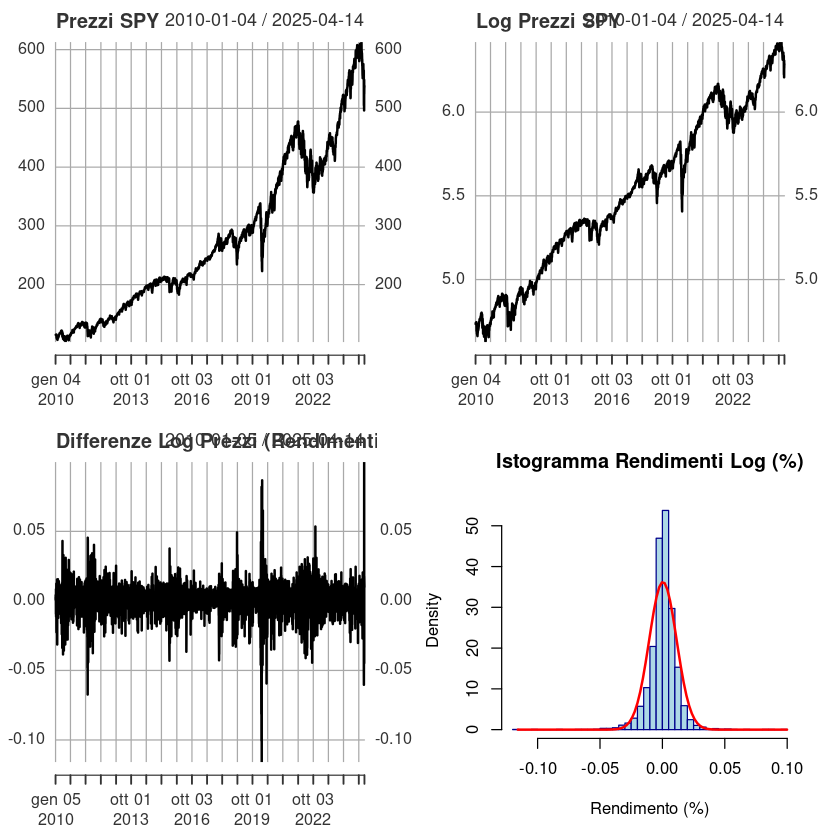

In [30]:
par(mfrow = c(2,2))
plot(spy_prices, main = "Prezzi SPY")
plot(log_prices, main = "Log Prezzi SPY")
plot(diff_log_prices, main = "Differenze Log Prezzi (Rendimenti, in %)")
diff_log_prices_num <- as.numeric(diff_log_prices)
hist(diff_log_prices_num, breaks = 50, probability = TRUE,
     main = "Istogramma Rendimenti Log (%)", 
     xlab = "Rendimento (%)", col = "lightblue", border = "darkblue")
x_vals <- seq(from = min(diff_log_prices_num), to = max(diff_log_prices_num), length.out = 100)
dens_vals <- dnorm(x_vals, mean = mean(diff_log_prices_num), sd = sd(diff_log_prices_num))
lines(x_vals, dens_vals, col = "red", lwd = 2)
par(mfrow = c(1,1))

### Verifica della stazionarietà (debole) della serie
Utilizzando l'Augmented Dickey-Fuller test, che suppone la non stazionarietà come ipotesi nulla possiamo capire se la serie è stazionaria in senso debole, condizione necessaria per l'applicazione di qualsiasi modello arima.

In [31]:
adf_result <- adf.test(diff_log_prices)
print(adf_result)

Warning message in adf.test(diff_log_prices):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  diff_log_prices
Dickey-Fuller = -16.386, Lag order = 15, p-value = 0.01
alternative hypothesis: stationary



Come ci aspettavamo la serie è debolmente stazionaria. Questo permette di poter trovare un modello arima per stimare la parte di medie e valutarne la parte di residui. Come prima cosa andiamo a plottare ACF e PACF per i rendimenti differenziati, che possono suggerire informazioni sugli ordini di AR e MA.

#### ACF
Misura la correlazione tra una serie temporale e se stessa spostata di un lag. Indica quanto è forte la correlazione tra $X_t$ e $X_{t-k}$. Quando l'ACF si azzera, la correlazione si annulla e questo suggerisce l'ordine della componente MA del modello.

#### PACF
Misura la correlazione diretta tra la serie e le sue versioni ritardate al lag $k$, controllando l'effetto dei lag intermenti. Fornisce l'autocorrelazione tra $X_t$ e $X_{t-k}$ quando si tengono costanti i restanti valori. Questo è particolarmente utile per determinare l'ordine della componente AR in un modello arima.


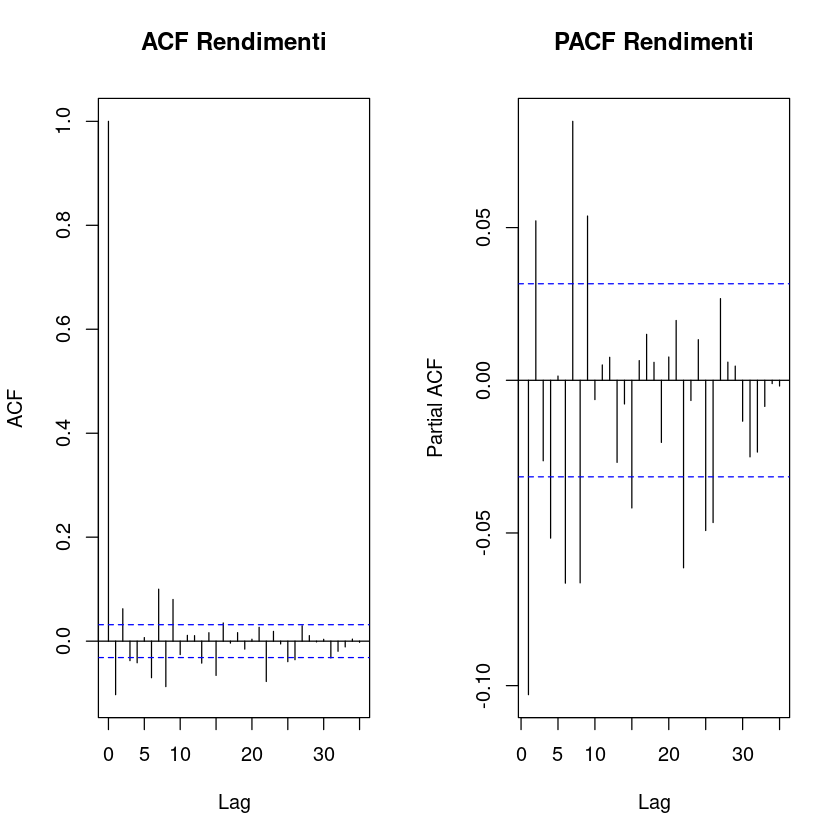

In [32]:
par(mfrow = c(1,2))
acf(diff_log_prices, main = "ACF Rendimenti")
pacf(diff_log_prices, main = "PACF Rendimenti")
par(mfrow = c(1,1))

Possiamo ora stimare i modelli ARIMA. Utilizzeremo per la ricerca modelli con $ p,q \leq 2$ per evitare overfitting e rendere l'interpretazione piu chiara. Questo ci permette di confrontare direttamente i modelli tramite criteri informativi come l'AIC, oltre ad ottenere una stima più stabile dei parametri.

In [33]:
#model named with 1 as integrating param due to preprocess
model_111 <- arima(diff_log_prices, order = c(1,0,1))
model_211 <- arima(diff_log_prices, order = c(2,0,1))
model_121 <- arima(diff_log_prices, order = c(1,0,2))
model_212 <- arima(diff_log_prices, order = c(2,0,2))
model_011 <- arima(diff_log_prices, order = c(0,0,1))
model_100 <- arima(diff_log_prices, order = c(1,0,0))
#aic index
cat("AIC modello ARIMA(1,1,1):", AIC(model_111), "\n")
cat("AIC modello ARIMA(2,1,1):", AIC(model_211), "\n")
cat("AIC modello ARIMA(1,1,2):", AIC(model_121), "\n")
cat("AIC modello ARIMA(2,1,2):", AIC(model_212), "\n")
cat("AIC modello ARIMA(0,1,1):", AIC(model_011), "\n")


AIC modello ARIMA(1,1,1): -23789.1 
AIC modello ARIMA(2,1,1): -23789.21 
AIC modello ARIMA(1,1,2): -23789.86 
AIC modello ARIMA(2,1,2): -23861.85 
AIC modello ARIMA(0,1,1): -23777.91 


Possiamo notare come il modello ARIMA(2,1,2) abbia AIC più basso e quindi sia il migliore per modellizzare la parte di media della nostra serie temporale. Siamo interessati ora a visualizzare i residui.

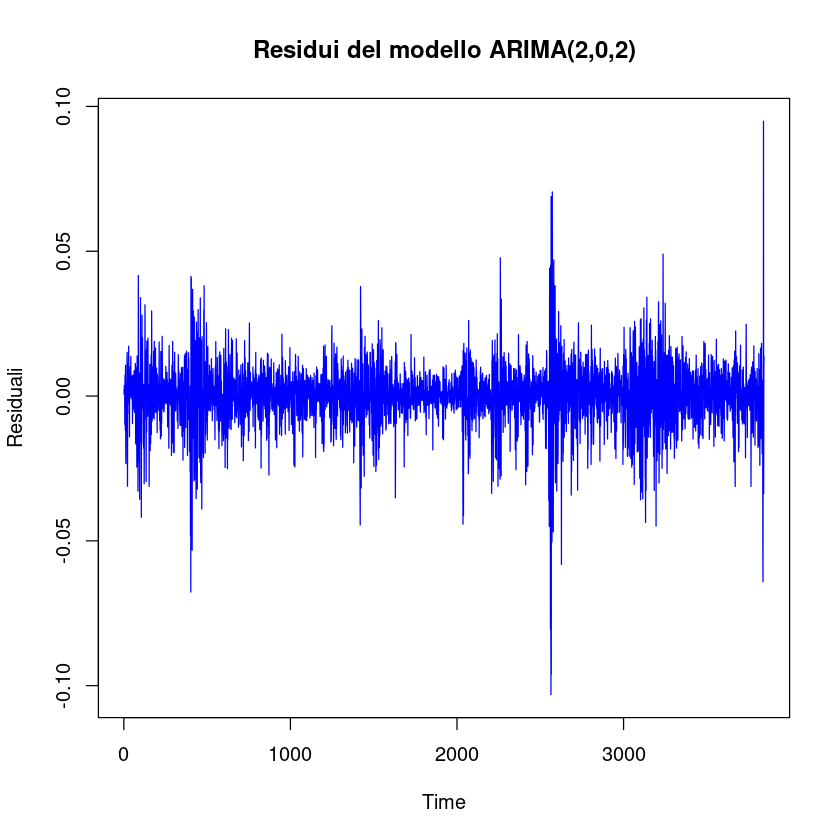

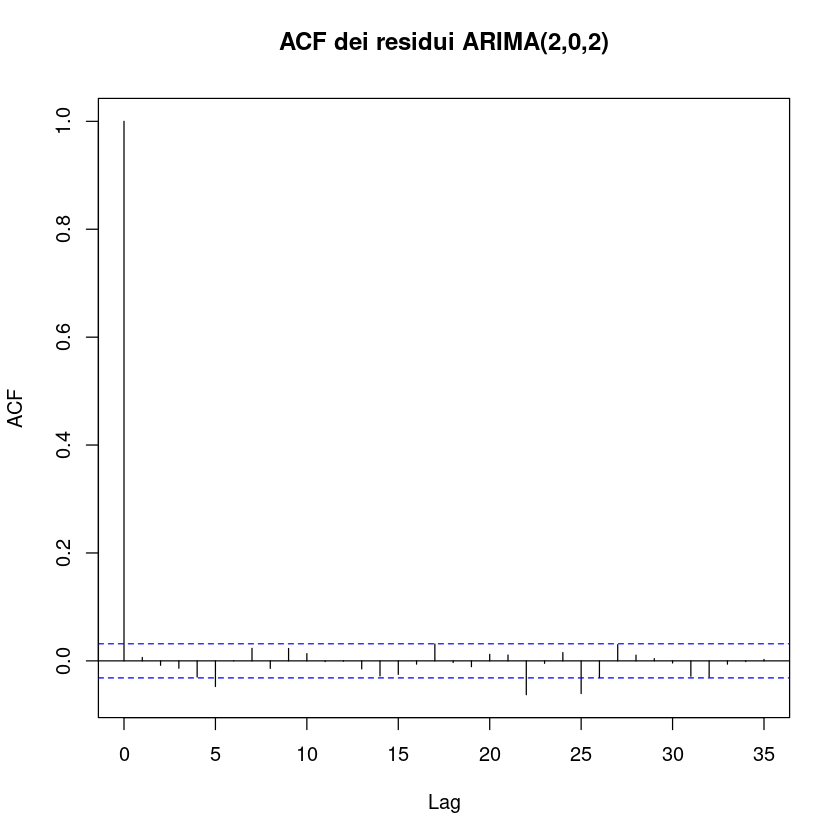

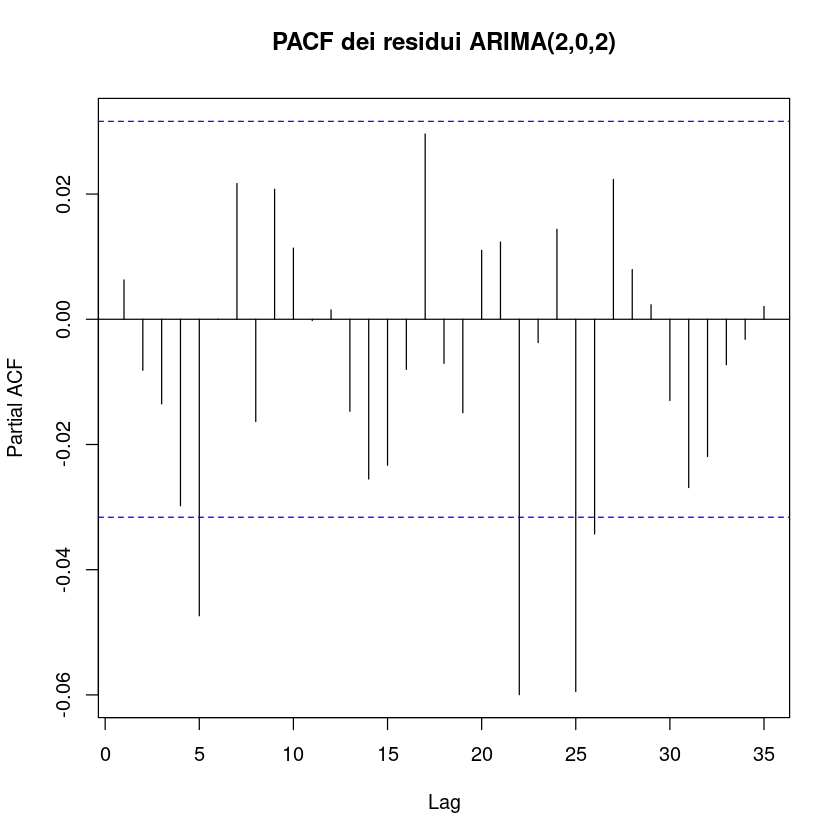

In [34]:
res_212 <- residuals(model_212)
#plot
plot(res_212, 
     main = "Residui del modello ARIMA(2,0,2)", 
     ylab = "Residuali", 
     col = "blue")
acf(res_212, 
    main = "ACF dei residui ARIMA(2,0,2)")   

pacf(res_212, 
     main = "PACF dei residui ARIMA(2,0,2)") 


### Autocorrelazione dei residui

Possiamo ora utilizzare il test Ljung-Box per verificare se i residui del modello mostrano autocorrelazioni significative fino ad un certo numero di lag. Il test confronta le autocorrelazioni osservate nei residui con quelle attese per una serie casuale. Questo permette di valutare eventuali effetti di clustering della volatilità per cui sarebbe ragionevole utilizzare un modello ARCH/GARCH.

In [35]:
#test on residuals
lb_test <- Box.test(res_212, lag = 20, type = "Ljung-Box")
cat("Ljung-Box test sui residui:\n")
print(lb_test)
#test on square residuals for ARCH/GARCH
lb_test_sq <- Box.test(res_212^2, lag = 20, type = "Ljung-Box")
cat("Ljung-Box test sui residui^2 (per effetti ARCH):\n")
print(lb_test_sq)

Ljung-Box test sui residui:



	Box-Ljung test

data:  res_212
X-squared = 29.964, df = 20, p-value = 0.07043

Ljung-Box test sui residui^2 (per effetti ARCH):

	Box-Ljung test

data:  res_212^2
X-squared = 3318, df = 20, p-value < 2.2e-16



I p-value bassi confermando l'idea iniziale : il p-value sui residui standard non permette di rifiutare l'ipotesi nulla, ovvero globalmente i residui non mostrano autocorrelazione significativa. La parte ARIMA ha dunque catturato in maniera efficace la struttura media della serie.
Tuttavia questo test valuta solo la parte lineare della serie e non la struttura della volatilità che viene efficacemente catturata dal secondo test effettuato, ovvero quello dei residui al quadrato. Infatti nel test dei residui al quadrato dobbiamo rifiutare l'ipotesi nulla, ammettendo l'esistenza di una forte correlazione. Questo è un segnale tipico di clustering della volatilità che motiva la necessità di implementare una componente ARCH/GARCH per modellizzare la varianza in modo condizionale.

In [80]:
spec_garch <- ugarchspec(
    variance.model = list(model="sGARCH", garchOrder = c(1,1)),
    mean.model = list(armaOrder = c(0,0), include.mean=FALSE),
    distribution.model = "norm"
)
#garch estimation
garch_fit <-ugarchfit(spec = spec_garch, data = as.numeric(res_212))
summary(garch_fit)
log_lik <- garch_fit@fit$LLH
num_param <- length(garch_fit@fit$coef)
aic <- -2*log_lik + 2*num_param
cat("AIC per GARCH(1,1): ",aic, ".\n")

   Length     Class      Mode 
        1 uGARCHfit        S4 

AIC per GARCH(1,1):  -25387.3 .


In [81]:
std_resid_normal <- garch_fit@fit$residuals/garch_fit@fit$sigma #std deviation
shapiro_test <- shapiro.test(std_resid_normal)
print(shapiro_test)


	Shapiro-Wilk normality test

data:  std_resid_normal
W = 0.97472, p-value < 2.2e-16



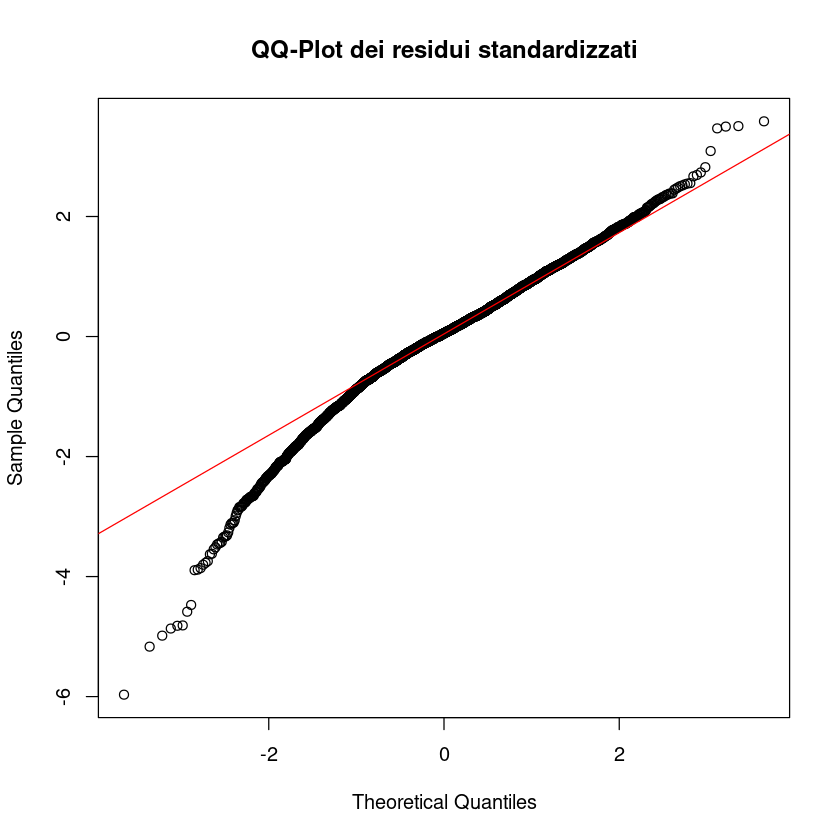

In [82]:
qqnorm(std_resid_normal, main="QQ-Plot dei residui standardizzati")
qqline(std_resid_normal, col="red")


### Normalità dei residui standardizzati

I due test rifiutano l'ipotesi di normalità dei residui standardizzati. Infatti, il test di normalità di Shapiro-Wilk presenta un p-value molto basso e dobbiamo quindi rifiutare l'ipotesi nulla. Questo rifiuto viene corroborato dal test qualitativo del QQ-plot: notiamo infatti come la coda di sinistra si discosti significativamente dalla diagonale ideale della normale. Possiamo quindi dedurre che le code siano più pesanti e asimmetriche rispetto ad una distribuzione normale. Verifichiamo queste ipotesi andando a controllare la skewness e la kurtosis dei rendimenti logaritmici e dei residui standardizzati.

In [85]:
library(moments)
#returns
skew_returns <- skewness(diff_log_prices)
cat("Return skewness: ", skew_returns,".\n")
#skew standardized residuals
skew_std_ret <- skewness(as.numeric(std_resid_normal))
cat("Standardized residuals skewness: ", skew_std_ret)

Return skewness:  -0.5586162 .
Standardized residuals skewness:  -0.6417484

Notiamo quindi che sia i rendimenti logaritmici che i residui standardizzati presentano asimmetrie negative, tipiche degli andamenti finanziari. La distribuzione dei rendimenti (e conseguentemente dei residui) ha una coda a sinistra più pesante, ovvero occasionalmente c sono rendimenti negativi più estremi rispetto alla media. Possiamo applicare il Jarque-Bera test per valutare l'ipotesi nulla secondo cui i dati hanno skewness pari a 0 e kurtosi pari a 3.

In [86]:
jb_test <- jarque.bera.test(std_resid_normal)
print(jb_test)
print(kurtosis(std_resid_normal))


	Jarque Bera Test

data:  std_resid_normal
X-squared = 835.07, df = 2, p-value < 2.2e-16

[1] 4.888856


Anche avendo già eseguito un test di normalità sui residui standardizzati il Jarque-Bera test ha lo scopo di verificare separatamente le deviazioni di skewness e kurtosis. Dato che il p-value è estremamente basso, dobbiamo rifiutare l'ipotesi nulla e concludere che la deviazione dalla normale è dovuta a significative differenze in skewness e kurtosis.

### t di Student
È possibile ipotizzare una t di Student come distribuzione per le volatilità condizionate nel modello GARCH, che dovrebbe mitigare almeno in parte il problema delle code pesanti.

In [ ]:
spec_garch <- ugarchspec(
    variance.model = list(model="sGARCH", garchOrder = c(1,1)),
    mean.model = list(armaOrder = c(0,0), include.mean=FALSE),
    distribution.model = "std"
)
#garch estimation
garch_fit <-ugarchfit(spec = spec_garch, data = as.numeric(res_212))
summary(garch_fit)
log_lik <- garch_fit@fit$LLH
num_param <- length(garch_fit@fit$coef)
aic <- -2*log_lik + 2*num_param
cat("AIC per student t: ",aic, ".\n")

   Length     Class      Mode 
        1 uGARCHfit        S4 

AIC per GARCH(1,1):  -25586.12 .


Possiamo già notare dall'AIC come questo modello sia preferibile al precedente. Tuttavia è interessante valutare come i residui si adattino ad una t di Student con grado di libertà stimato dal modello.

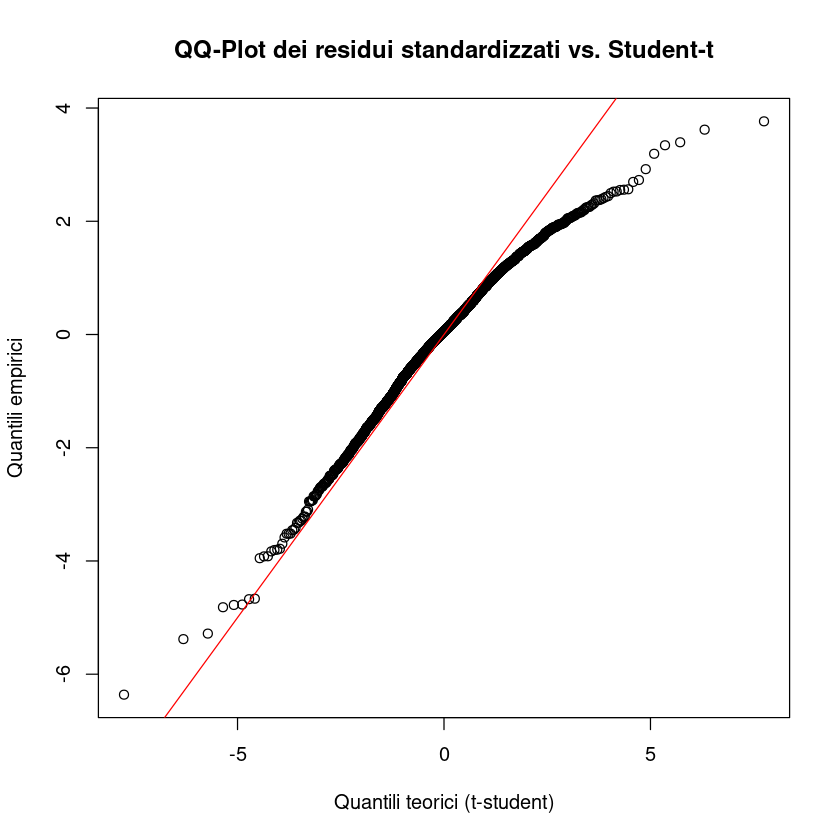

In [92]:
std_resid_t <- residuals(garch_fit, standardize = TRUE)
std_resid_t <- as.numeric(coredata(std_resid_t))
#freedom degrees
df <- as.numeric(garch_fit@fit$coef[["shape"]])
#theorical distribution
theo_q <- qt(ppoints(length(std_resid_t)),df = df)
qqplot(theo_q, std_resid_t, 
       main = "QQ-Plot dei residui standardizzati vs. Student-t",
       xlab = "Quantili teorici (t-student)",
       ylab = "Quantili empirici")
abline(0, 1, col = "red")

In [ ]:
spec_garch <- ugarchspec(
    variance.model = list(model="sGARCH", garchOrder = c(1,1)),
    mean.model = list(armaOrder = c(0,0), include.mean=FALSE),
    distribution.model = "std"
)
#garch estimation
garch_fit <-ugarchfit(spec = spec_garch, data = as.numeric(res_212))
summary(garch_fit)
log_lik <- garch_fit@fit$LLH
num_param <- length(garch_fit@fit$coef)
aic <- -2*log_lik + 2*num_param
cat("AIC per student t: ",aic, ".\n")

   Length     Class      Mode 
        1 uGARCHfit        S4 

AIC per GARCH(1,1):  -25586.12 .


### Migliore fit rispetto alla normale

Nel nuovo QQ-plot notiamo che i residui aderiscono meglio alla diagonale dei quantili teorica. Le deviazioni risultano attenuate rispetto al QQ-plot della normale, suggerendo una modellizzazione più efficace delle caratteristiche della serie.

### Skewed t
È interessante verificare come l'utilizzo di una skewed t (t di Student asimmetrica) possa migliorare l'aderenza dei residui alla distribuzione teorica.


In [101]:
#sstd
spec_garch_sstd <- ugarchspec(
  variance.model = list(model = "sGARCH", garchOrder = c(1,1)),
  mean.model     = list(armaOrder = c(0,0), include.mean = FALSE),
  distribution.model = "sstd"
)
garch_fit_sstd <- ugarchfit(spec = spec_garch_sstd, data = as.numeric(res_212))
aic_sstd <- -2*garch_fit_sstd@fit$LLH + 2*length(garch_fit_sstd@fit$coef)
cat("AIC skewed t:",aic_sstd,".\n")


AIC skewed t: -25645.89 .


Notiamo come l'AIC per il modello sia migliore rispetto al modello precendente. Ipotizziamo dunque una migliore aderenza alla distribuzione teorica dei residui che verrà verificata qualitativamente tramite QQ-plot.

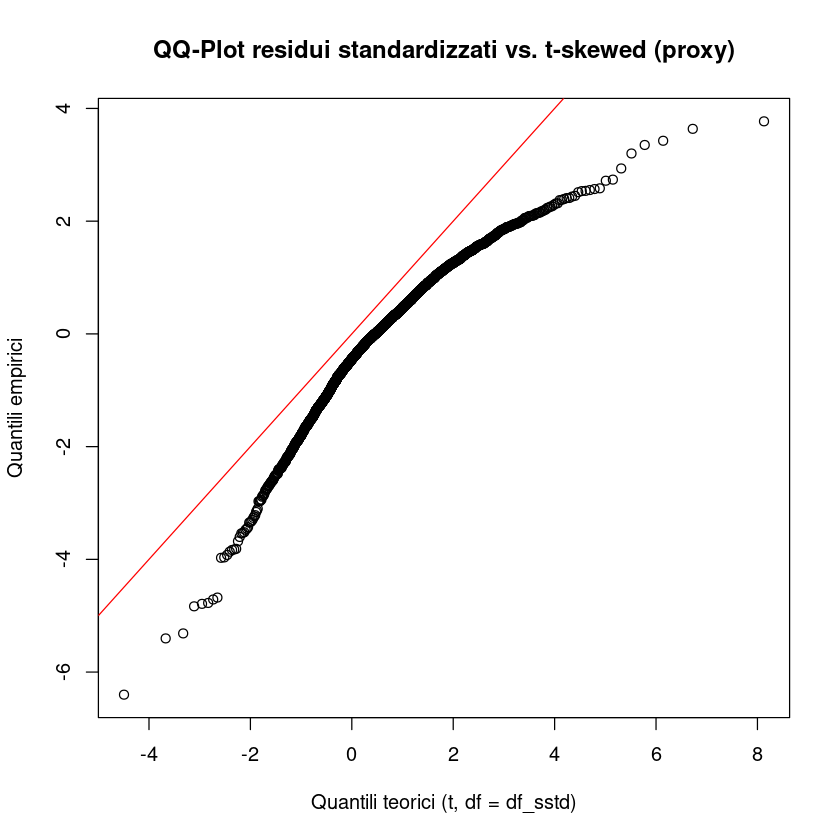

In [99]:
library(sn)
std_resid_sstd <- residuals(garch_fit_sstd, standardize = TRUE)
std_resid_sstd <- as.numeric(coredata(std_resid_sstd))
#qqplot with skewness and freedom degrees
params <-garch_fit_sstd@fit$coef
df_sstd <- as.numeric(params["shape"])
skew_sstd <- as.numeric(params["skew"])
#theorical quantiles
theo_q_sstd <- qst(ppoints(length(std_resid_sstd)), alpha = skew_sstd, nu = df_sstd)
#qqplot
qqplot(theo_q_sstd, std_resid_sstd, 
       main = "QQ-Plot residui standardizzati vs. t-skewed (proxy)",
       xlab = "Quantili teorici (t, df = df_sstd)",
       ylab = "Quantili empirici")
abline(0,1, col = "red")


Il QQ-plot risulta qualitativamente peggiore rispetto al caso della t di Student normale. Tuttavia, è necessario valutare i risultati in termini di forecasting. Se i risultati sono più robusti, andremo a preferire il secondo modello e la mancata aderenza del QQ-plot potrebbe non essere determinante.